In [1]:
# Example 1: Reinforcement Learning Training Workflow

In [2]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt
import time

from typing import Optional, Union

import jax
import jax.numpy as jnp
from jax import jit, vmap, block_until_ready, config

from algos.ppo import PPO_make_train

In [3]:
# Seeding all Random Number Generation during the RL Training for Reproducibility

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

## Photon Langevin Env

For this notebook, we work on the Photon Langevin Environment, where we are trying to improve Single Qubit Readout of a Superconducting Transmon Qubit. The physical system we deal with is of a Transmon Qubit Dispersively Coupled to a Microwave Cavity, ie a Readout Resonator. Treating the Transmon Qubit as a Non-Linear Quantum Harmonic Oscillator (QHO) and the Readout Resonator as a QHO, we can model the dynamics of the open system under an arbitrary input drive pulse on the resonator using Input-Output Theory and the Quantum Langevin Equation.

To simplify simulations and analysis, we use the Coherent Langevin Equations where we assume the Resonator is in a Coherent State, a valid approximation for the regimes labs typically operate in, such as IBM Quantum devices. By solving the differential equations from the Coherent Langevin Equations, we can simulate both the phase and photon population of the Resonator as a function of time. From this we extract figures of merit, such as maximum photon population, maximum fidelity, time to reset the resonator, to pass to our reward function and hence have an overall RL Environment to train on!

In [4]:
# Defining Cairo Params and RL Params

tau_0 = 0.398
kappa = 25.0
chi = 0.65
kerr = 0.002
gamma = 1/100
time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff = 10.0
rough_max_photons = 31
rough_max_amp_scaled = 1/0.43
actual_max_photons = rough_max_photons * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {rough_max_photons}")
print(f"Actual Max Photons: {actual_max_photons}")
ideal_photon = 1e-2
scaling_factor = 7.5
gamma_I = 1/500
num_t1 = 8.0
photon_gamma = 1/2000
init_fid = 1 - 1e-3

batchsize = 64
num_envs = 8
num_updates = 2500
config = {
    "LR": 3e-3,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": batchsize,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(batchsize * num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 256,
    "ENV_NAME": "photon_langevin_readout_env",
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 31
Actual Max Photons: 30.573151382405857


In [5]:
single_train = jit(PPO_make_train(config), static_argnums=(-2, -1))

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result = single_train(
    _rng, 
    kappa, 
    chi, 
    kerr,
    gamma,
    time_coeff,
    snr_coeff,
    smoothness_coeff,
    rough_max_photons,
    actual_max_photons,
    rough_max_amp_scaled,
    ideal_photon,
    scaling_factor,
    gamma_I,
    num_t1,
    photon_gamma,
    init_fid,
    batchsize, 
    num_envs)
print(f"time taken: {time.time() - start}")

Starting a Run of 2500 Updates
global update: 100
mean batch reward: [14.12193494 14.32604556 13.90298432 13.90305779 13.09333891 14.68361782
 14.14889529 14.25218171]
mean batch pF: [1.80404499 1.79700408 1.7907919  1.78460215 1.80477436 1.78499544
 1.78758373 1.80421207]
mean batch photon: [29.31196976 28.87573624 28.94770813 28.74414062 29.33361435 28.79169273
 28.75476265 29.25710869]
mean batch photon time: [0.23213892 0.23438734 0.23449618 0.23568673 0.2345105  0.23272381
 0.23293759 0.23541228]
mean batch smoothness: [0.00131202 0.00093872 0.00178297 0.00095587 0.00186236 0.0014593
 0.00176108 0.00127884]
max reward obtained: [16.42224108 16.43998199 16.54290668 16.3396397  16.25272116 16.44089771
 16.71456819 16.48834889]
pF at max: [1.78502412 1.74950605 1.82117451 1.87085013 1.86322525 1.85813652
 1.87324526 1.85009061]
photon at max: [30.20568466 27.34117126 30.2494278  30.57815552 31.40569878 31.65733719
 31.4747982  30.34700966]
photon time of max: [0.23644444 0.22939664 0

In [6]:
# Extracting Results

metrics = single_result["metrics"]

max_actions = metrics["action of max"]
max_rewards = metrics["max reward obtained"]
max_photons = metrics["photon at max"]
max_pFs = metrics["pF at max"]
max_times = metrics["photon time of max"]
mean_rewards = metrics["mean batch reward"]
mean_pFs = metrics["mean batch pF"]
mean_photons = metrics["mean batch photon"]
mean_photon_times = metrics["mean batch photon time"]

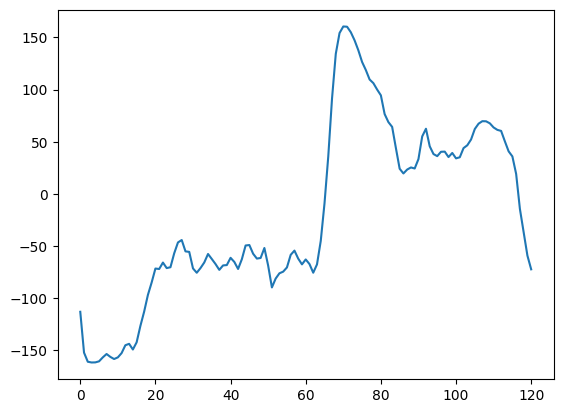

In [7]:
plt.plot(max_actions[-1, 0])

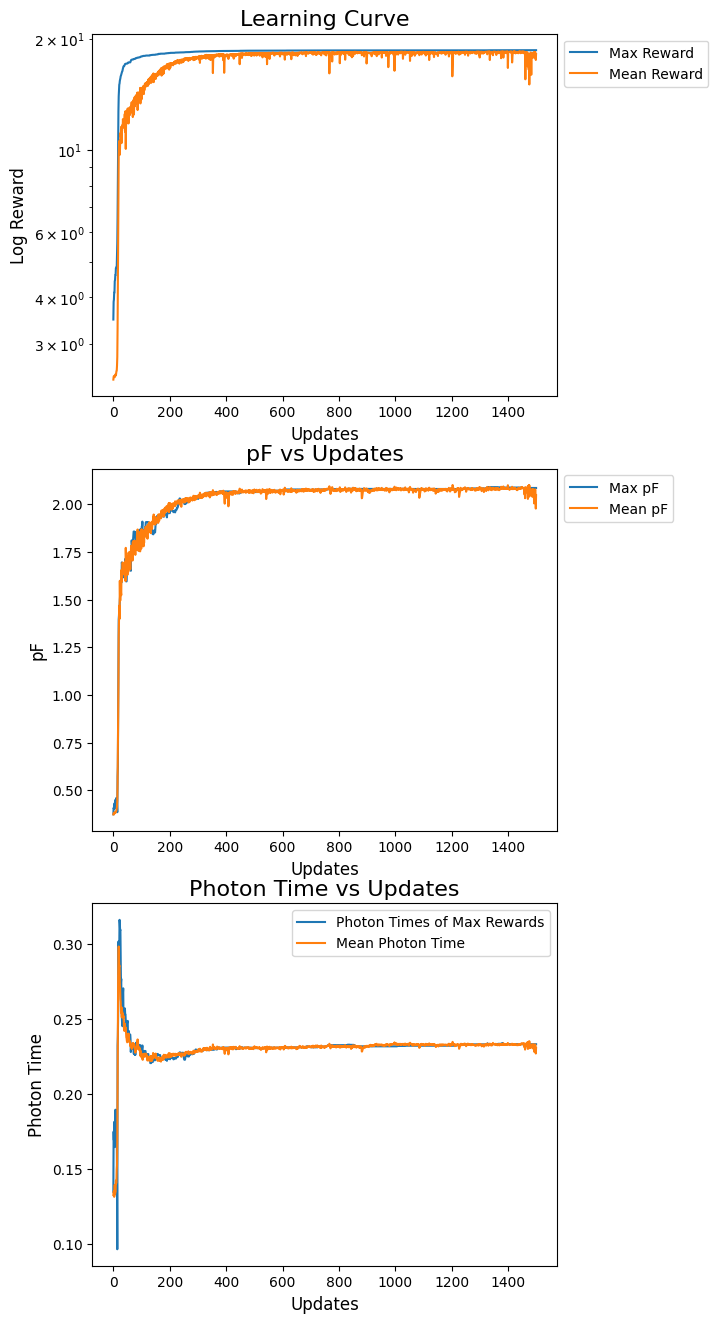

In [7]:
# Evaluating the Learning Curve and Learning Metrics

def plot_general_stats(results_obj, end_update: int, xsize: Optional[int] = 12, tsize: Optional[int] = 20):

    a, b, c = jnp.arange(3)

    fig, ax = plt.subplots(3, figsize=(6.0, 16.0))

    max_rewards = jnp.mean(metrics["max reward obtained"], axis=1)[:end_update]
    mean_rewards = jnp.mean(metrics["mean batch reward"], axis=1)[:end_update]

    max_pFs = jnp.mean(metrics["pF at max"], axis=1)[:end_update]
    mean_pFs = jnp.mean(metrics["mean batch pF"], axis=1)[:end_update]

    max_times = jnp.mean(metrics["photon time of max"], axis=1)[:end_update]
    mean_photon_times = jnp.mean(metrics["mean batch photon time"], axis=1)[:end_update]

    ax[a].plot(max_rewards, label=f'Max Reward')
    ax[a].plot(mean_rewards, label=f'Mean Reward')

    ax[b].plot(max_pFs, label=f'Max pF')
    ax[b].plot(mean_pFs, label=f'Mean pF')

    ax[c].plot(max_times, label=f'Photon Times of Max Rewards')
    ax[c].plot(mean_photon_times, label=f'Mean Photon Time')

    b_plot = (1., 1.)
    ysize = xsize

    ax[a].legend(bbox_to_anchor=b_plot)
    ax[a].set_xlabel('Updates', fontsize=xsize)
    ax[a].set_ylabel('Log Reward', fontsize=ysize)
    ax[a].set_yscale('log')
    ax[a].set_title('Learning Curve', fontsize=tsize)

    ax[b].legend(bbox_to_anchor=b_plot)
    ax[b].set_xlabel('Updates', fontsize=xsize)
    ax[b].set_ylabel('pF', fontsize=ysize)
    ax[b].set_title('pF vs Updates', fontsize=tsize)

    ax[c].legend(bbox_to_anchor=b_plot)
    ax[c].set_xlabel('Updates', fontsize=xsize)
    ax[c].set_ylabel('Photon Time', fontsize=ysize)
    ax[c].set_title('Photon Time vs Updates', fontsize=tsize)

    plt.show()

plot_general_stats(metrics, end_update=1500, xsize=12, tsize=16)